# <font color='#1a5276'> <b> <center> Initialization techniques </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4)
5. [Model](#5)
6. [Initialization methods](#6) <br>
    6.1. [PyTroch default initialization](#6.1) <br>
    6.2. [Bad initialization](#6.2) <br>
7. [Conclusions](#7)
8. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In deep learning, the choice of weight initialization can significantly impact the performance and convergence of neural networks. Proper initialization helps prevent issues like vanishing or exploding gradients, leading to faster training and improved results.

This notebook explores different weight initialization techniques, including Xavier and He initialization, demonstrating how they affect the performance of neural networks. By the end, you'll see how selecting the right initialization can improve training stability and model accuracy.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [3]:
torch.manual_seed(0)

<a name="3"></a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

<a name="4"></a>
## <font color='blue'> <b> 4. Data </b> </font>

We will use the MNIST dataset.

In [7]:
# Create the train dataset
train_dataset = dsets.MNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())

In [8]:
# Create the validation dataset
validation_dataset = dsets.MNIST(root='data/', train=False, download=True, transform=transforms.ToTensor())

In [9]:
# Create Dataloader for both train dataset and validation dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a name="5"></a>
## <font color='blue'> <b> 5. Model and training function </b> </font>

In [18]:
input_dim = 28 * 28 # 28x28 greyscale images
output_dim = 10 # 10 classes
layers = [input_dim, 100, 10, 100, 10, 100, output_dim]
epochs = 15
learning_rate = 0.01

In [11]:
class Net(nn.Module):
    # Constructor
    def __init__(self, Layers, init_method=None):
        """
        Parameters:
        - Layers: list of integers defining the layer sizes.
        - init_method: a callable function for weight initialization (e.g., torch.nn.init.xavier_uniform_).
                       If None, uses PyTorch's default initialization.
        """
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            
            # Apply the custom initialization method if provided
            if init_method is not None:
                init_method(linear.weight)
            
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x


'\n# Example usage\nLayers = [10, 20, 10, 1]\n\n# Using Xavier initialization\nnet_xavier = DynamicNet(Layers, init_method=torch.nn.init.xavier_uniform_)\n\n# Using He initialization\nnet_he = DynamicNet(Layers, init_method=torch.nn.init.kaiming_uniform_)\n\n# Using default initialization\nnet_default = DynamicNet(Layers)\n'

In [14]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs = 100):
    i = 0
    loss_accuracy = {'training_loss':[], 'validation_accuracy':[]}  
    
    for epoch in range(epochs):
        for i,(x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_accuracy['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label==y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        loss_accuracy['validation_accuracy'].append(accuracy)
        
    return loss_accuracy

In [15]:
# Define criterion function
criterion = nn.CrossEntropyLoss()

### Model 1: Using default initialization

In [16]:
model = Net(layers)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

In [17]:
training_results

{'training_loss': [2.3059420585632324,
  2.3062903881073,
  2.30808162689209,
  2.3045475482940674,
  2.3022868633270264,
  2.3094356060028076,
  2.3045191764831543,
  2.3103110790252686,
  2.3094775676727295,
  2.302915096282959,
  2.308953046798706,
  2.3058536052703857,
  2.306755304336548,
  2.3051533699035645,
  2.3052446842193604,
  2.3046460151672363,
  2.305248498916626,
  2.308133125305176,
  2.3074605464935303,
  2.305445671081543,
  2.3004496097564697,
  2.3087158203125,
  2.306094169616699,
  2.3015403747558594,
  2.302672863006592,
  2.3044092655181885,
  2.302786350250244,
  2.30069899559021,
  2.303025245666504,
  2.306601047515869,
  2.3046987056732178,
  2.303302764892578,
  2.305450439453125,
  2.3047564029693604,
  2.304011821746826,
  2.3010337352752686,
  2.3010241985321045,
  2.3055686950683594,
  2.3037686347961426,
  2.3071353435516357,
  2.3015992641448975,
  2.3046817779541016,
  2.301118850708008,
  2.30355167388916,
  2.3038015365600586,
  2.3014438152313232

### Model 2: Xavier Initialization

In [24]:
model_2 = Net(layers, init_method=torch.nn.init.xavier_uniform_)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=learning_rate)
training_results_2 = train(model_2, criterion, train_loader, validation_loader, optimizer_2, epochs=epochs)

### Model 3: He Initialization

In [25]:
model_he = Net(layers, init_method = torch.nn.init.kaiming_uniform_)


# quizás ver los params.

optimizer_he = torch.optim.SGD(model_he.parameters(), lr=learning_rate)
training_results_he = train(model_he, criterion, train_loader, validation_loader, optimizer_he, epochs=epochs)

### Model 4: Uniform Initialization

In [30]:
model_uniform = Net(layers, init_method = torch.nn.init.uniform_)
optimizer_uniform = torch.optim.SGD(model_uniform.parameters(), lr=learning_rate)
training_results_uniform = train(model_uniform, criterion, train_loader, validation_loader, 
                                 optimizer_uniform, epochs=epochs)

In [36]:

# in an annex, telling a little about the diffrent types

w = torch.empty(3, 5)
print(w)
nn.init.uniform_(w)
print(w)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4013e-45, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[0.5946, 0.6474, 0.8462, 0.4766, 0.5640],
        [0.7333, 0.7708, 0.0889, 0.7305, 0.6962],
        [0.4934, 0.8082, 0.2847, 0.0696, 0.3860]])


In [ ]:
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.uniform_

In [ ]:
# el apply de arriba en un anexo; igula que el recorrido de código

<a name="6"></a>
## <font color='blue'> <b> 6. Comparing results </b> </font>

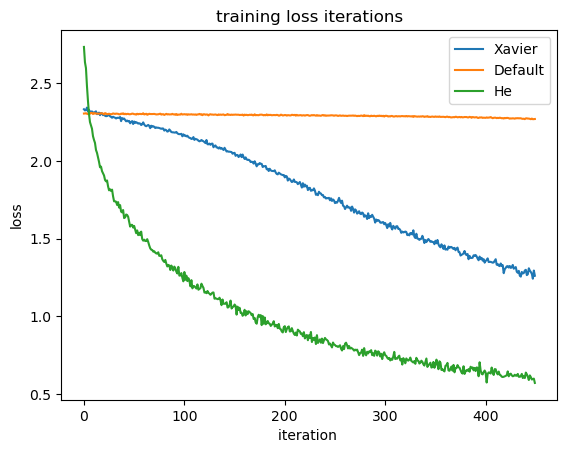

In [32]:
# Plot the loss

plt.plot(training_results_2['training_loss'], label='Xavier')
plt.plot(training_results['training_loss'], label='Default')
plt.plot(training_results_he['training_loss'], label='He')
#plt.plot(training_results_uniform['training_loss'], label='Uniform')
plt.ylabel('loss')
plt.xlabel('iteration ')  
plt.title('training loss iterations')
plt.legend()

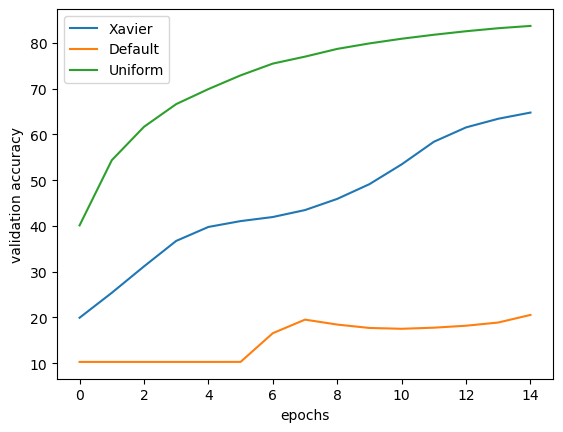

In [38]:
plt.plot(training_results_2['validation_accuracy'], label='Xavier')
plt.plot(training_results['validation_accuracy'], label='Default')
plt.plot(training_results_he['validation_accuracy'], label='Uniform') 
plt.ylabel('validation accuracy')
plt.xlabel('epochs')   
plt.legend()